In [11]:
!pip install koreanize-matplotlib
import koreanize_matplotlib  # 한글 폰트 적용

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 66.5 MB/s eta 0:00:00


/tmp/ipython-input-1-2508074576.py:36: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1-2508074576.py:36: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1-2508074576.py:36: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1-2508074576.py:36: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1-2508074576.py:36: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1-2508074576.py:36: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1-2508074576.py:36: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight

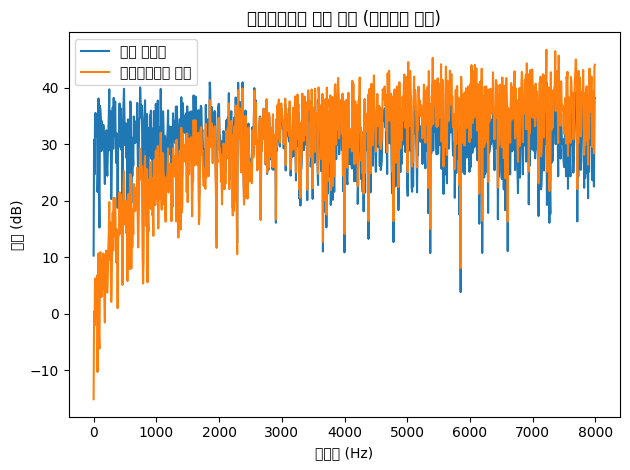

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# 1. 파라미터 설정
#1 원본 연속신호를 sample하기 위해 원본 신호가 갖는 최대주파수의 2배에 해당하는 주파수를 sampling rate로 설정하여 sampling한다.
fs = 16000            # 샘플링 주파수 (Hz)=sampling rate, 기존 신호내 최대주파수의 2배
duration = 1.0        # 신호 길이 (초)
N = int(fs * duration)

# 2. 랜덤 노이즈 생성(화이트 노이즈)
#2 전체 주파수에 대한 dB값이 비교적 일정한 화이트 노이즈를 생성한다.
noise = np.random.randn(N)

# 3.생성된 노이즈에 프리엠파시스 필터 적용
#3 생성된 화이트 노이즈에 pre-empahsis를 적용하여 에너지가 작은 부분을 보상한다.
alpha = 0.97
noise_pre = np.append(noise[0], noise[1:] - alpha * noise[:-1])
#현재 샘플에서 이전 샘플의 일부(0.97배)를 빼서 고주파 성분을 강조

# 4. DFT 계산
#4 이때 화이트 노이즈가 시간 영역에서 표현되는 여러 신호가 섞여 있는 하나의 이산신호이다.
#이를 어떤 주파수를 갖는 신호가 섞여 있는 지 분석하기 위해 주파수 영역으로 전환시킨다.
NFFT = 2048
freqs = fftfreq(NFFT, 1/fs)[:NFFT//2]

spec = np.abs(fft(noise, NFFT))[:NFFT//2]
spec_pre = np.abs(fft(noise_pre, NFFT))[:NFFT//2]

# 5. dB 스케일로 변환
spec_db     = 20 * np.log10(spec     + 1e-8)
spec_pre_db = 20 * np.log10(spec_pre + 1e-8)

# 6. 스펙트럼 시각화
plt.figure()
plt.plot(freqs, spec_db,     label='원본 노이즈')
plt.plot(freqs, spec_pre_db, label='프리엠파시스 적용')
plt.title('프리엠파시스 필터 효과 (스펙트럼 비교)')
plt.xlabel('주파수 (Hz)')
plt.ylabel('크기 (dB)')
plt.legend()
plt.tight_layout()
plt.show()

Hamming window

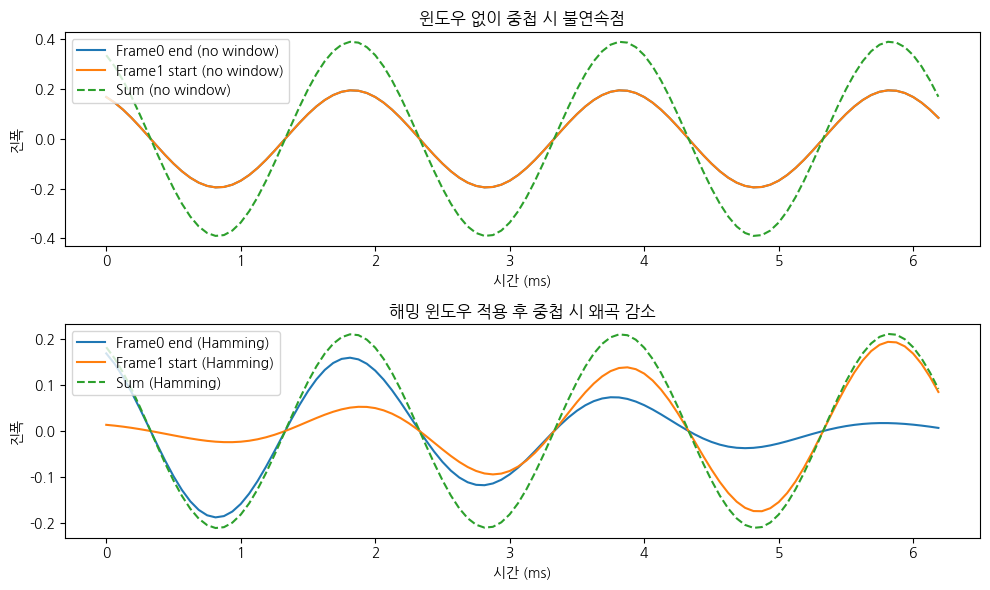

파일로 저장됨:  500 Hz_tone_hopping_demo.wav


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.io.wavfile import write
from IPython.display import Audio, display

# 1. 파라미터 설정
fs = 16000               # 샘플링 주파수 (Hz)
f0 = 500               # 톤 주파수 (Hz)
duration = 0.1          # 신호 길이 (초)
t = np.linspace(0, duration, int(fs*duration), endpoint=False)

# 2. 1 kHz 정현파(파장이 정해져 있는 신호->파장이 정해져 있기에 주파수도 1개이다) 생성
x = np.sin(2 * np.pi * f0 * t) #-> t는 시간, f0은 기본주파수

# 3. 프리엠파시스 -> 에너지가 약한 자음을 보상하기 위함
pre_emphasis = 0.97
x_pre = np.append(x[0], x[1:] - pre_emphasis * x[:-1])

# 4. 프레이밍 및 호핑(쪼갤 때 오버랩 구간) -> signal를 겹치게 쪼갠다.
frame_len = 200         # 프레임 길이 (샘플, 약 25 ms)
hop_len   = 100         # 호핑 길이 (샘플, 약 12.5 ms)
# ->frame길이가 200일 때 호핑 길이가 100이므로 1/2 겹치게 쪼개는 것이다. 왜냐 1/2일 때가 가장 안정적이다.
# 두 개의 연속된 프레임 추출
frame0 = x_pre[:frame_len]
frame1 = x_pre[hop_len:hop_len+frame_len]

# 5. 해밍 윈도우 적용
# -> 나중에 합칠 때 겹치는 부분이 중복되어 합쳐져 원래보다 증폭되어 왜곡되는 것을 방지하기 위해 hamming window사용
win = np.hamming(frame_len)
frame0_win = frame0 * win
frame1_win = frame1 * win
#윈도우 함수 적용 다음 스펙트럼을 구하기 위해 푸리에 변환을 한다.
# 6. 겹치는 구간 추출
reg0_no  = frame0[-hop_len:]       # 윈도우 전, 프레임0 끝부분
reg1_no  = frame1[:hop_len]        # 윈도우 전, 프레임1 시작부분
reg0_win = frame0_win[-hop_len:]   # 윈도우 후, 프레임0 끝부분
reg1_win = frame1_win[:hop_len]    # 윈도우 후, 프레임1 시작부분

# 7. 겹침 합산
overlap_sum_no  = reg0_no  + reg1_no
overlap_sum_win = reg0_win + reg1_win

# 8. 시간축 (ms)
time_hop = np.arange(hop_len) / fs * 1000

# 9. 시각화
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.plot(time_hop, reg0_no,  label='Frame0 end (no window)')
plt.plot(time_hop, reg1_no,  label='Frame1 start (no window)')
plt.plot(time_hop, overlap_sum_no, '--', label='Sum (no window)')
plt.title('윈도우 없이 중첩 시 불연속점')
plt.xlabel('시간 (ms)')
plt.ylabel('진폭')
plt.legend()

plt.subplot(2,1,2)
plt.plot(time_hop, reg0_win,  label='Frame0 end (Hamming)')
plt.plot(time_hop, reg1_win,  label='Frame1 start (Hamming)')
plt.plot(time_hop, overlap_sum_win, '--', label='Sum (Hamming)')
plt.title('해밍 윈도우 적용 후 중첩 시 왜곡 감소')
plt.xlabel('시간 (ms)')
plt.ylabel('진폭')
plt.legend()

plt.tight_layout()
plt.show()

# 10. 재생 및 저장
display(Audio(x, rate=fs))
write('0.5kHz_tone_hopping_demo.wav', fs, (x * 32767).astype(np.int16))
print('파일로 저장됨: ' ,f0, 'Hz_tone_hopping_demo.wav')

프레임 윈도우 효과

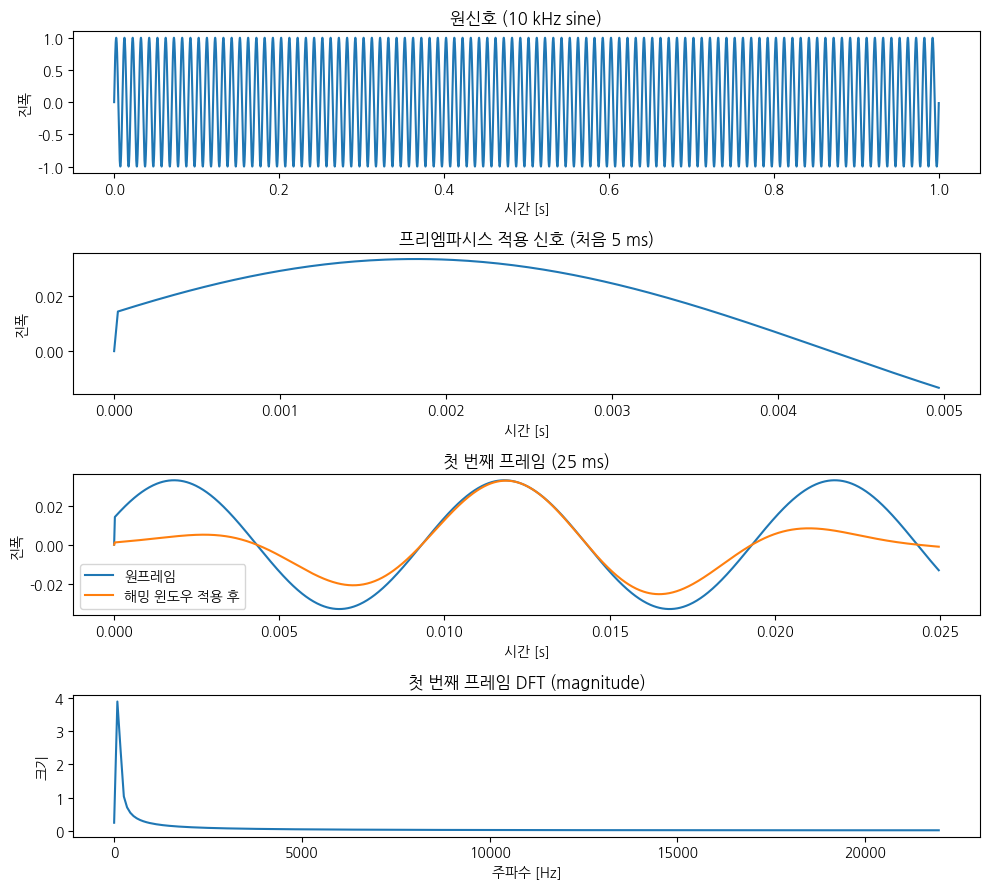

10kHz_tone.wav 파일로 저장되었습니다.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.io.wavfile import write
from IPython.display import Audio, display

# 1. 파라미터 설정
# sampling 하기 위해 설정
fs = 44100           # 샘플링 주파수 (Hz)
f0 = 100           # 톤 주파수 (Hz)
duration = 1.0       # 신호 길이 (초)
t = np.linspace(0, duration, int(fs*duration), endpoint=False)

# 2. 10 kHz 정현파 생성
x = np.sin(2 * np.pi * f0 * t)

# 3. 프리엠파시스 (차분 고역 강조)
# 이는 에너지가 약한 부분인 자음을 보상하기 위한 작업이다.
pre_emphasis = 0.97
x_pre = np.append(x[0], x[1:] - pre_emphasis * x[:-1])

# 4. 프레이밍 (25 ms 프레임, 10 ms 스텝)
# 시간 영역에서 표현되는 이산 신호를 frame단위로 쪼갠다.
frame_size = 0.025   # 초 -> frame의 크기
frame_step = 0.01    # 초 -> 호핑의 크기
frame_len = int(frame_size * fs)
step_len  = int(frame_step * fs)

num_frames = int(np.ceil((len(x_pre) - frame_len) / step_len)) + 1
pad_len = (num_frames - 1) * step_len + frame_len
x_padded = np.append(x_pre, np.zeros(pad_len - len(x_pre)))

indices = (np.tile(np.arange(frame_len), (num_frames, 1)) +
           np.tile(np.arange(0, num_frames*step_len, step_len), (frame_len, 1)).T)
frames = x_padded[indices.astype(int)]

# 5. 해밍 윈도우 적용 (NumPy)
# 나중에 frame단위로 쪼갠 것을 합칠 때 겹치게 쪼갠 부분의 왜곡을 줄이기 위해 해밍 윈도우 적용
win = np.hamming(frame_len)
frames_win = frames * win

# 6. DFT (첫 번째 프레임에 대해)
# 여러 신호가 섞인 시간 영역에서 표현되는 이산 신호를 분석하기 위해 주파수 영역에서 표현하기 위해 DFT적용
NFFT = 512
spec = fft(frames_win[0], n=NFFT)
mag = np.abs(spec)[:NFFT//2]
freqs = fftfreq(NFFT, 1/fs)[:NFFT//2]

# 7. 시각화
plt.figure(figsize=(10, 9))

# 원 신호
plt.subplot(4,1,1)
plt.plot(t, x)
plt.title('원신호 (10 kHz sine)')
plt.xlabel('시간 [s]')
plt.ylabel('진폭')

# 프리엠파시스 신호 (처음 5 ms)
plt.subplot(4,1,2)
plt.plot(t[:int(0.005*fs)], x_pre[:int(0.005*fs)])
plt.title('프리엠파시스 적용 신호 (처음 5 ms)')
plt.xlabel('시간 [s]')
plt.ylabel('진폭')

# 첫 프레임 (윈도우 전/후)
frame_t = np.arange(frame_len) / fs
plt.subplot(4,1,3)
plt.plot(frame_t, frames[0], label='원프레임')
plt.plot(frame_t, frames_win[0], label='해밍 윈도우 적용 후')
plt.title('첫 번째 프레임 (25 ms)')
plt.xlabel('시간 [s]')
plt.ylabel('진폭')
plt.legend()

# 스펙트럼
plt.subplot(4,1,4)
plt.plot(freqs, mag)
plt.title('첫 번째 프레임 DFT (magnitude)')
plt.xlabel('주파수 [Hz]')
plt.ylabel('크기')

plt.tight_layout()
plt.show()

# 8. 재생 및 저장
display(Audio(x, rate=fs))            # 노트북에서 바로 듣기
write('10kHz_tone.wav', fs,           # 16-bit PCM WAV 파일로 저장
      (x * 32767).astype(np.int16))
print('10kHz_tone.wav 파일로 저장되었습니다.')

Hopping에 의한 Overlap 왜곡

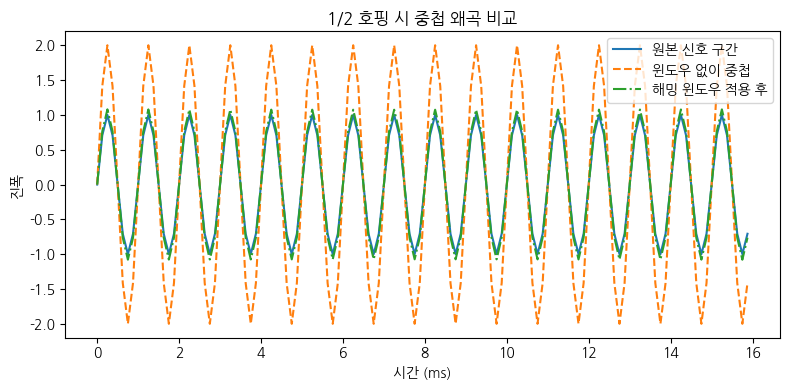

MSE without window: 0.500000
MSE with Hamming:  0.002920


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
cut=2

# 1. 파라미터 설정
fs       = 8000               # 샘플링 주파수 (Hz)
f0       = 1000               # 톤 주파수 (Hz)
duration = 0.05               # 신호 길이 (초)
t        = np.linspace(0, duration, int(fs*duration), endpoint=False)
x        = np.sin(2 * np.pi * f0 * t)

# 2. 프레임 & 호핑 설정 (1/cut 호핑)
#-> 호핑은 1/2일 때 겹쳤을 때의 왜곡이 가장 작은데 연산량이 가장 많아서 연산시간이 오래걸린다.
frame_len = 256              # 프레임 길이 (샘플)
hop_len   = frame_len //cut   # 1/cut 호핑 -> 이 비율만큼 frame이 중복된다.

# 3. 두 프레임 추출
frame0 = x[:frame_len]  #-> 전체 신호에서 처음 256만큼 짜름
frame1 = x[hop_len:hop_len+frame_len] #-> 그 다음 호핑만큼 겹쳐서 256만큼 짜른다.

# 4. 겹침 영역 계산 (원본)
orig_region    = x[hop_len:frame_len]  # 길이 = frame_len - hop_len

# 5. 윈도우 없이 중첩
overlap_no = frame0[hop_len:] + frame1[:frame_len-hop_len]
#겹쳐진 부분의 왜곡은 그대로 발생한다.

# 6. 해밍 윈도우 적용 후 중첩
#겹쳐진 부분의 왜곡이 #5보다는 적은 상태로 나타난다.
win        = np.hamming(frame_len)
f0_win     = frame0 * win
f1_win     = frame1 * win
overlap_win = f0_win[hop_len:] + f1_win[:frame_len-hop_len]

# 7. 시간축 (ms)
time_ms = np.arange(len(orig_region)) / fs * 1000

# 8. 시각화
plt.figure(figsize=(8, 4))
plt.plot(time_ms, orig_region,      label='원본 신호 구간')
plt.plot(time_ms, overlap_no, '--', label='윈도우 없이 중첩')
plt.plot(time_ms, overlap_win, '-.', label='해밍 윈도우 적용 후')
plt.title('1/2 호핑 시 중첩 왜곡 비교')
plt.xlabel('시간 (ms)')
plt.ylabel('진폭')
plt.legend()
plt.tight_layout()
plt.show()

# 9. 왜곡 정도 계산 (MSE)
mse_no  = np.mean((overlap_no  - orig_region)**2)
mse_win = np.mean((overlap_win - orig_region)**2)
print(f'MSE without window: {mse_no:.6f}')
print(f'MSE with Hamming:  {mse_win:.6f}')

librosa로 Mel-Spectrogram 계산

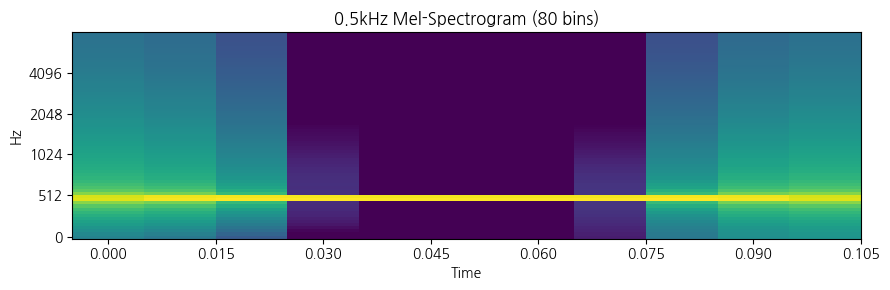

In [ ]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 1) 음원 로드 (예: 16 kHz, 모노로 유지)
wav_path = "/content/0.5kHz_tone_hopping_demo.wav"
y, sr = librosa.load(wav_path, sr=16000)

# 2) 전처리: 프리-엠퍼시스(선택) + 정규화
y = np.append(y[0], y[1:] - 0.97 * y[:-1])
y = y / np.abs(y).max()

# 3) Mel-Spectrogram 파라미터
n_fft      = 1024          # 64 ms
hop_length = 160           # 10 ms
n_mels     = 80            # Mel 필터 수

# 4) Mel-Spectrogram
mel = librosa.feature.melspectrogram(
    y=y, sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    fmin=0.0, fmax=sr/2,
    power=2.0               # |X|²
)

# 5) dB 변환과 표준화
mel_db  = librosa.power_to_db(mel, ref=np.max)
mel_std = (mel_db - mel_db.mean()) / mel_db.std()

# 6) 시각화
plt.figure(figsize=(9, 3))
librosa.display.specshow(
    mel_std,
    sr=sr, hop_length=hop_length,
    x_axis="time", y_axis="mel",
    cmap="viridis"
)
plt.title("0.5kHz Mel-Spectrogram (80 bins)")
plt.tight_layout(); plt.show()

STFT 결과를 직접 활용해 Mel 필터 적용

In [ ]:
!pip install -q soundfile

In [ ]:
#라이브러리
from google.colab import output
from base64 import b64decode
from IPython.display import Audio, display
import io
import soundfile as sf

RECORD_SEC = 3

In [ ]:
# JavaScript 코드: 마이크 녹음 및 base64 반환
#웹 브라우저에서 마이크를 설정하기 위한 코드
record_js = f"""
async function recordAudio() {{
  const sleep = time => new Promise(resolve => setTimeout(resolve, time));
  const b2text = blob => new Promise(resolve => {{
    const reader = new FileReader();
    reader.onloadend = () => resolve(reader.result);
    reader.readAsDataURL(blob);
  }});

  let stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
  let recorder = new MediaRecorder(stream);
  let data = [];

  recorder.ondataavailable = event => data.push(event.data);
  recorder.start();

  await sleep({RECORD_SEC * 1000});
  recorder.stop();

  await new Promise(resolve => recorder.onstop = resolve);
  let blob = new Blob(data);
  return await b2text(blob);
}}
recordAudio();
"""

print(f"▶ 마이크 녹음을 {RECORD_SEC}초 동안 시작합니다...")
audio_base64 = output.eval_js(record_js)

# base64 디코딩 및 저장
audio_bytes = b64decode(audio_base64.split(',')[1])
with open("recorded.wav", "wb") as f:
    f.write(audio_bytes)

display(Audio("recorded.wav"))

▶ 마이크 녹음을 3초 동안 시작합니다...


/tmp/ipython-input-60-2632596315.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(wav_path, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


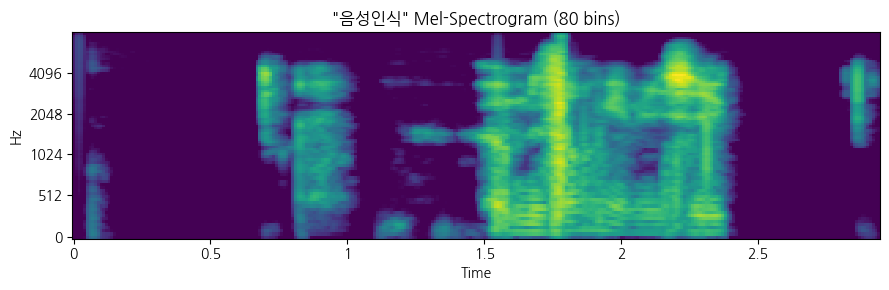

In [ ]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 1) 음원 로드 (예: 16 kHz, 모노로 유지)
wav_path = "recorded.wav"
y, sr = librosa.load(wav_path, sr=16000)

# 2) 전처리: 프리-엠퍼시스(선택) + 정규화
y = np.append(y[0], y[1:] - 0.97 * y[:-1])
y = y / np.abs(y).max()

# 3) Mel-Spectrogram 파라미터
n_fft      = 1024          # 64 ms
hop_length = 160           # 10 ms
n_mels     = 80            # Mel 필터 수

# 4) Mel-Spectrogram
mel = librosa.feature.melspectrogram(
    y=y, sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    fmin=0.0, fmax=sr/2,
    power=2.0               # |X|²
)

# 5) dB 변환과 표준화
mel_db  = librosa.power_to_db(mel, ref=np.max)
mel_std = (mel_db - mel_db.mean()) / mel_db.std()

# 6) 시각화
plt.figure(figsize=(9, 3))
librosa.display.specshow(
    mel_std,
    sr=sr, hop_length=hop_length,
    x_axis="time", y_axis="mel",
    cmap="viridis"
)
plt.title('"음성인식" Mel-Spectrogram (80 bins)')
plt.tight_layout(); plt.show()

In [ ]:
import librosa, numpy as np

y, sr = librosa.load("recorded.wav", sr=16000)
y = y / np.abs(y).max()

# STFT
n_fft, hop = 1024, 160
stft = librosa.stft(y, n_fft=n_fft, hop_length=hop, window="hann", center=False)
power_spec = np.abs(stft) ** 2

# Mel 필터뱅크 행렬
mel_fb = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=80, fmin=0.0, fmax=sr/2)
mel_spec = np.dot(mel_fb, power_spec)        # (80, frame)

mel_db = librosa.power_to_db(mel_spec, ref=np.max)

/tmp/ipython-input-56-4151923140.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load("recorded.wav", sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


프로젝트용 공개 데이터셋

In [ ]:
# FSDD 음원 다운로드
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git
!mv free-spoken-digit-dataset/recordings recordings

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 33.49 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [ ]:
#FSDD 데이터 웨이브데이터 로딩 후 멜 스펙트럼 변환
import librosa, glob
import numpy as np

files = glob.glob("FSDD/recordings/*.wav")
mel_list = []

for fp in files:
    y, _ = librosa.load(fp, sr=16000)
    mel = librosa.feature.melspectrogram(y=y, sr=16000, n_fft=1024,
                                         hop_length=160, n_mels=80, power=2)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_list.append(mel_db)

In [ ]:
#저장된 멜 스펙트럼 시각화
num_samples = min(5, len(mel_list))  # 최대 5개만

plt.figure(figsize=(12, 2.5 * num_samples))

for i in range(num_samples):
    plt.subplot(num_samples, 1, i + 1)
    librosa.display.specshow(mel_list[i], sr=16000, hop_length=160,
                             x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spectrogram #{i + 1}')

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1200x0 with 0 Axes>

librosa 기본 실습

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 9.98 MiB/s, done.
Resolving deltas: 100% (129/129), done.
샘플레이트: 16000
신호 길이: 10296
오디오 길이(초): 0.6435


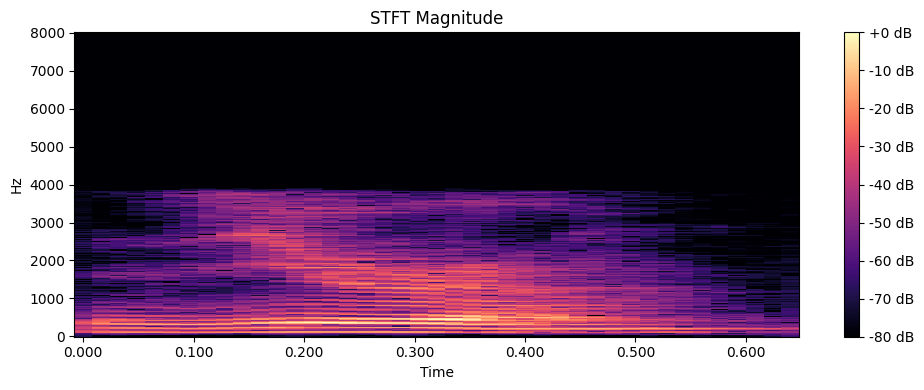

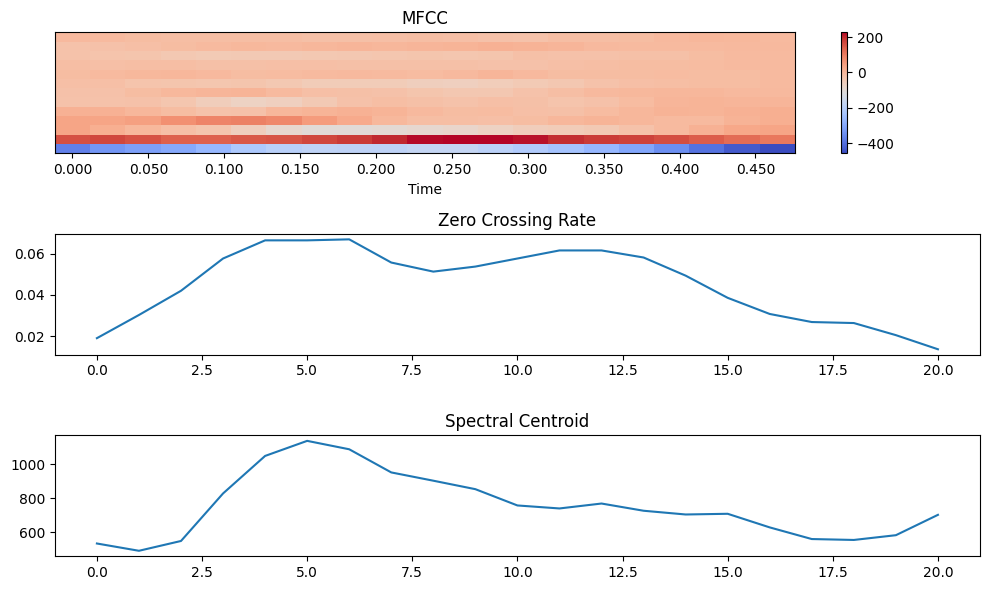

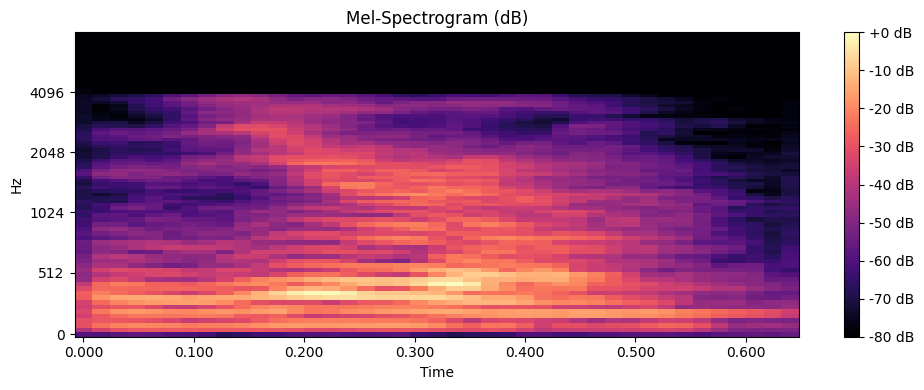

0.5초, 1.0초에 해당하는 프레임: [31 62]
프레임 → 시간: [0.496 0.992]


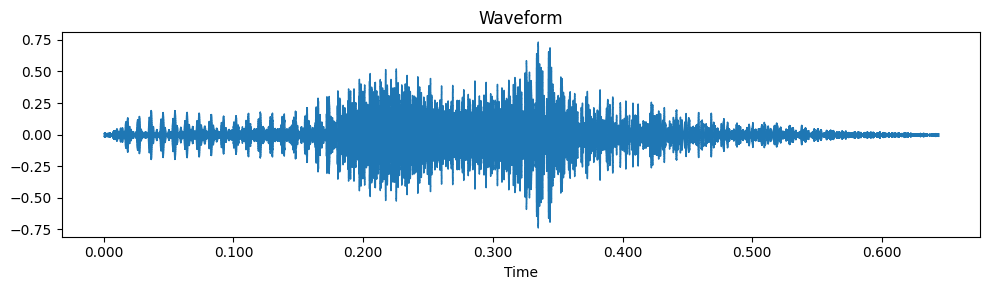

프레임 수: 198


In [1]:
# =============================
# FSDD 음원 다운로드 및 준비
# =============================
# FSDD(Free Spoken Digit Dataset) GitHub에서 클론
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

# recordings 폴더만 이동
!mv free-spoken-digit-dataset/recordings recordings

# =============================
# 라이브러리 로드 -> 신호 전처리 및 시각화를 위한 library호출
# =============================
import librosa                   # 오디오 처리 라이브러리
import librosa.display           # 시각화 유틸리티
import soundfile as sf          # 오디오 저장
import numpy as np              # 수치 계산
import matplotlib.pyplot as plt # 시각화

# =============================
# 0. FSDD 음원 로드
# =============================
audio_path = 'recordings/0_jackson_0.wav'  # 0번 숫자를 발음한 파일
y, sr = librosa.load(audio_path, sr=16000) # 16kHz로 로딩
#y는 audio_path가 가리키는 오디오 샘플을 가리키고
#y를 실행시키기 위해 sampling rate가 필요하다.
# =============================
# 2-1. 오디오 입출력  -> y가 가리키는 오디오 파일을 1초에 sampling rate만큼 쪼갠다.
# =============================
print("샘플레이트:", sr)                           # 샘플레이트 출력
print("신호 길이:", len(y))                        # 샘플 수 출력
print("오디오 길이(초):", librosa.get_duration(y=y, sr=sr))  # 총 재생 시간(초)

sf.write("fsdd_output.wav", y, sr)                # 오디오를 파일로 저장

# =============================
# 2-2. 신호 처리 (STFT 및 복원) ->  시간 영역에 표현된 신호를 주파수 영역으로 표현하고 진폭만 추출 후, 이후 역변환 실행
# =============================
n_fft = 1024                      # 프레임당 FFT 크기
hop_length = 256                 # 홉 크기
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)  # STFT 계산
magnitude = np.abs(D)            # 복소수 STFT에서 진폭만 추출
y_reconstructed = librosa.istft(D, hop_length=hop_length) # 역변환 수행(주파수 영역->시간 영역)

# STFT 결과 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max),
                         sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.title("STFT Magnitude")      # 제목
plt.colorbar(format="%+2.0f dB") # 데시벨 범례
plt.tight_layout()
plt.show()

# =============================
# 2-3. 특징 추출 (MFCC, ZCR, Centroid)
#-> 신호에서 무의미한 부분은 제외하고 유의미한 부분에 한에서만 mel filter bank적용 후 DCT처리하여 MFCC를 추출한다.
#이를 하는 이유는 사람이 들을 수 있는 부분만 특정하기 위해서이다.
# =============================
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)        # MFCC 추출 (13차원)
zcr = librosa.feature.zero_crossing_rate(y)               # 제로 크로싱 비율
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # 스펙트럼 중심

# 특징 시각화
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
librosa.display.specshow(mfcc, x_axis='time')     # MFCC 시각화
plt.title('MFCC')
plt.colorbar()

plt.subplot(3, 1, 2)
plt.plot(zcr[0])                                  # ZCR 시각화
plt.title('Zero Crossing Rate')

plt.subplot(3, 1, 3)
plt.plot(centroid[0])                             # 스펙트럼 중심 시각화
plt.title('Spectral Centroid')
plt.tight_layout()
plt.show()

# =============================
# 2-4. 단위 변환 (Power ↔ dB)
# =============================
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                     hop_length=hop_length, n_mels=80)  # 멜 스펙트로그램 계산
mel_db = librosa.power_to_db(mel, ref=np.max)                           # dB 스케일로 변환

# 멜 스펙트로그램 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram (dB)')
plt.tight_layout()
plt.show()

# =============================
# 2-5. 시간-프레임 변환
# =============================
frame_idx = librosa.time_to_frames([0.5, 1.0], sr=sr, hop_length=hop_length)  # 0.5초, 1초 → 프레임 인덱스
print("0.5초, 1.0초에 해당하는 프레임:", frame_idx)

times = librosa.frames_to_time(frame_idx, sr=sr, hop_length=hop_length)      # 프레임 인덱스 → 시간
print("프레임 → 시간:", times)

# =============================
# 2-6. 시각화 (Waveform)
# =============================
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)  # 파형 시각화
plt.title("Waveform")
plt.tight_layout()
plt.show()

# =============================
# 2-7. 유틸리티 함수 (정규화, 고정 길이, 프레이밍)
#
# =============================
from librosa.util import normalize, fix_length, frame

y_norm = normalize(y)                             # 에너지 정규화
y_fixed = fix_length(y_norm, size=sr * 2)         # 2초 길이로 고정
frames = frame(y_fixed, frame_length=400, hop_length=160)  # 프레임 분할
print("프레임 수:", frames.shape[1])             # 프레임 개수 출력

librosa 연습문제

**문제 1. 오디오 앞 1초 자르기**

FSDD에서 로드한 오디오 `y`와 샘플레이트 `sr`이 주어졌을 때, 앞부분 **1초 구간만 자르고** 새로운 파일 `new_output.wav`로 저장하세요.

In [3]:
# =============================
# FSDD 음원 다운로드 및 준비
# =============================
# FSDD(Free Spoken Digit Dataset) GitHub에서 클론
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

# recordings 폴더만 이동
!mv free-spoken-digit-dataset/recordings recordings

# =============================
# 라이브러리 로드
# =============================
import librosa                   # 오디오 처리 라이브러리
import librosa.display           # 시각화 유틸리티
import soundfile as sf          # 오디오 저장
import numpy as np              # 수치 계산
import matplotlib.pyplot as plt # 시각화

# =============================
# 0. FSDD 음원 로드
# =============================
audio_path = 'recordings/0_jackson_0.wav'  # 0번 숫자를 발음한 파일
y, sr = librosa.load(audio_path, sr=16000) # 16kHz로 로딩

# =============================
# 2-1. 오디오 입출력
# =============================
print("샘플레이트:", sr)                           # 샘플레이트 출력
print("신호 길이:", len(y))                        # 샘플 수 출력
print("오디오 길이(초):", librosa.get_duration(y=y, sr=sr))  # 총 재생 시간(초)
sf.write("new_output.wav", y[:sr], sr)
#샘플레이트 `sr`이 16000이면, 1초는 16000개의 샘플입니다.
#따라서 `y[:sr]`는 앞 1초 구간을 의미하며,
#이를 `soundfile.write()`로 저장하면 새로운 오디오 파일이 생성됩니다.
sf.write("fsdd_output.wav", y, sr)                # 오디오를 파일로 저장


fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.
mv: cannot stat 'free-spoken-digit-dataset/recordings': No such file or directory
샘플레이트: 16000
신호 길이: 10296
오디오 길이(초): 0.6435


**문제 2. MFCC 평균값 계산**

`librosa.feature.mfcc()`를 사용해 구한 `mfcc` 배열은 `(13, T)` 형태입니다.

이때 **각 차원별 평균값을 구하고**, `(13,)` 형태의 벡터로 출력하세요.

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.
mv: cannot stat 'free-spoken-digit-dataset/recordings': No such file or directory
샘플레이트: 16000
신호 길이: 10296
오디오 길이(초): 0.6435


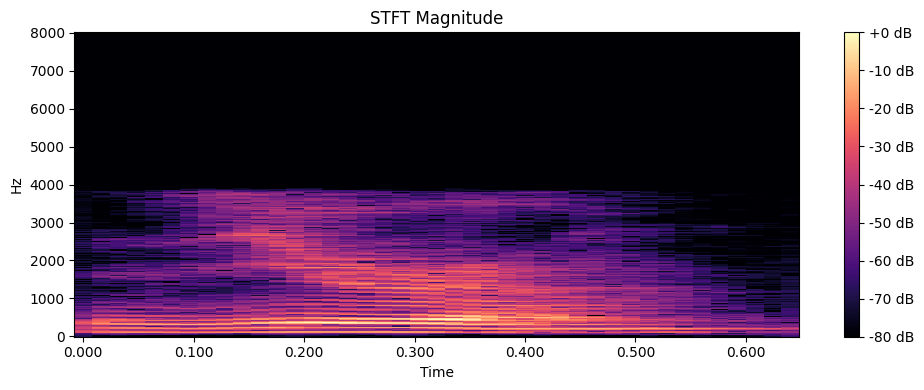

(13,)
[-275.36722    173.50085    -37.115707    23.888851    -1.3903315
  -23.278955   -12.555717   -32.69294     -6.854406   -16.229553
  -27.784616    -3.436688   -12.854584 ]


In [4]:
# =============================
# FSDD 음원 다운로드 및 준비
# =============================
# FSDD(Free Spoken Digit Dataset) GitHub에서 클론
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

# recordings 폴더만 이동
!mv free-spoken-digit-dataset/recordings recordings

# =============================
# 라이브러리 로드
# =============================
import librosa                   # 오디오 처리 라이브러리
import librosa.display           # 시각화 유틸리티
import soundfile as sf          # 오디오 저장
import numpy as np              # 수치 계산
import matplotlib.pyplot as plt # 시각화

# =============================
# 0. FSDD 음원 로드
# =============================
audio_path = 'recordings/0_jackson_0.wav'  # 0번 숫자를 발음한 파일
y, sr = librosa.load(audio_path, sr=16000) # 16kHz로 로딩

# =============================
# 2-1. 오디오 입출력
# =============================
print("샘플레이트:", sr)                           # 샘플레이트 출력
print("신호 길이:", len(y))                        # 샘플 수 출력
print("오디오 길이(초):", librosa.get_duration(y=y, sr=sr))  # 총 재생 시간(초)

sf.write("fsdd_output.wav", y, sr)                # 오디오를 파일로 저장

# =============================
# 2-2. 신호 처리 (STFT 및 복원)
# =============================
n_fft = 1024                      # 프레임당 FFT 크기
hop_length = 256                 # 홉 크기
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)  # STFT 계산
magnitude = np.abs(D)            # 복소수 STFT에서 진폭만 추출
y_reconstructed = librosa.istft(D, hop_length=hop_length) # 역변환 수행

# STFT 결과 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max),
                         sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.title("STFT Magnitude")      # 제목
plt.colorbar(format="%+2.0f dB") # 데시벨 범례
plt.tight_layout()
plt.show()

# =============================
# 2-3. 특징 추출 (MFCC, ZCR, Centroid)
# =============================
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)        # MFCC 추출 (13차원)
zcr = librosa.feature.zero_crossing_rate(y)               # 제로 크로싱 비율
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # 스펙트럼 중심
mfcc_mean = np.mean(mfcc, axis=1)
print(mfcc_mean.shape)
print(mfcc_mean)
#`mfcc`의 shape은 `(13, T)`로, 13차원 MFCC가 시간 축을 따라 존재합니다.

#`axis=1`로 평균을 구하면 각 MFCC 차원의 전체 시간 평균값을 계산하게 되며, `(13,)` 벡터가 됩니다.

#이 벡터는 분류기 입력 등에도 사용됩니다

**문제 3. ZCR이 높은 프레임 수 구하기**

제로 크로싱 레이트 `zcr` 배열은 `(1, T)`입니다.

이 중 **ZCR이 0.1 이상인 프레임의 개수**를 출력하세요.

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.
mv: cannot stat 'free-spoken-digit-dataset/recordings': No such file or directory
샘플레이트: 16000
신호 길이: 10296
오디오 길이(초): 0.6435


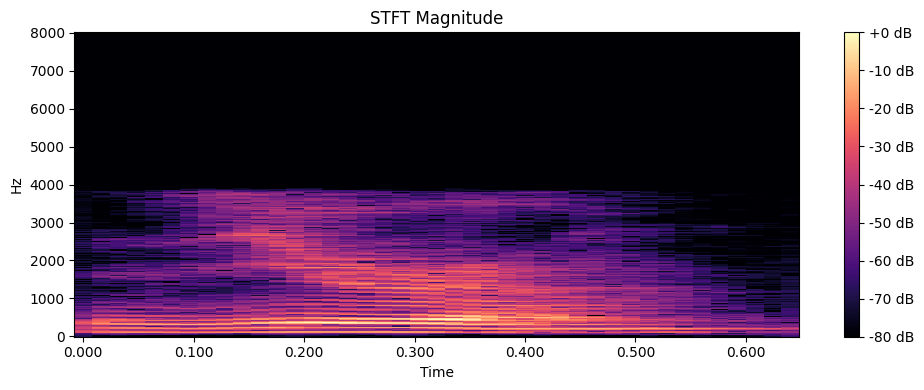

ZCR ≥ 0.1인 프레임 수: 0


In [5]:
# =============================
# FSDD 음원 다운로드 및 준비
# =============================
# FSDD(Free Spoken Digit Dataset) GitHub에서 클론
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

# recordings 폴더만 이동
!mv free-spoken-digit-dataset/recordings recordings

# =============================
# 라이브러리 로드
# =============================
import librosa                   # 오디오 처리 라이브러리
import librosa.display           # 시각화 유틸리티
import soundfile as sf          # 오디오 저장
import numpy as np              # 수치 계산
import matplotlib.pyplot as plt # 시각화

# =============================
# 0. FSDD 음원 로드
# =============================
audio_path = 'recordings/0_jackson_0.wav'  # 0번 숫자를 발음한 파일
y, sr = librosa.load(audio_path, sr=16000) # 16kHz로 로딩

# =============================
# 2-1. 오디오 입출력
# =============================
print("샘플레이트:", sr)                           # 샘플레이트 출력
print("신호 길이:", len(y))                        # 샘플 수 출력
print("오디오 길이(초):", librosa.get_duration(y=y, sr=sr))  # 총 재생 시간(초)

sf.write("fsdd_output.wav", y, sr)                # 오디오를 파일로 저장

# =============================
# 2-2. 신호 처리 (STFT 및 복원)
# =============================
n_fft = 1024                      # 프레임당 FFT 크기
hop_length = 256                 # 홉 크기
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)  # STFT 계산
magnitude = np.abs(D)            # 복소수 STFT에서 진폭만 추출
y_reconstructed = librosa.istft(D, hop_length=hop_length) # 역변환 수행

# STFT 결과 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max),
                         sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.title("STFT Magnitude")      # 제목
plt.colorbar(format="%+2.0f dB") # 데시벨 범례
plt.tight_layout()
plt.show()

# =============================
# 2-3. 특징 추출 (MFCC, ZCR, Centroid)
# =============================
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)        # MFCC 추출 (13차원)
zcr = librosa.feature.zero_crossing_rate(y)               # 제로 크로싱 비율
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # 스펙트럼 중심
num_high_zcr = np.sum(zcr[0] >= 0.1)
print(f"ZCR ≥ 0.1인 프레임 수: {num_high_zcr}")
#`zcr[0]`은 시간 축에 따라 ZCR 값이 들어 있는 배열입니다.

#이 중 `0.1` 이상인 값의 개수를 `np.sum()`으로 세면
#무성음·유성음 분석이나 경계 탐지 등에 활용할 수 있습니다.

**문제 4. 멜 스펙트로그램 평균 벡터 만들기**

멜 스펙트로그램 `mel_db`의 shape은 `(80, T)`입니다.

이 데이터를 시간 축으로 평균 내어 **80차원의 벡터**를 만드세요.

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.
mv: cannot stat 'free-spoken-digit-dataset/recordings': No such file or directory
샘플레이트: 16000
신호 길이: 10296
오디오 길이(초): 0.6435


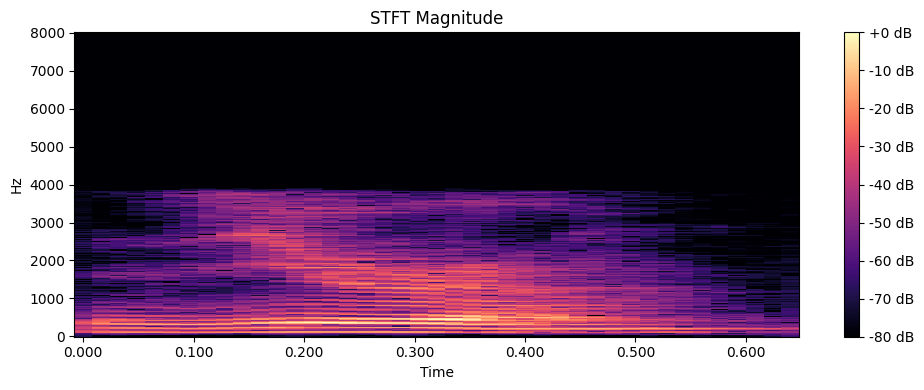

(80,)


In [6]:
# =============================
# FSDD 음원 다운로드 및 준비
# =============================
# FSDD(Free Spoken Digit Dataset) GitHub에서 클론
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

# recordings 폴더만 이동
!mv free-spoken-digit-dataset/recordings recordings

# =============================
# 라이브러리 로드
# =============================
import librosa                   # 오디오 처리 라이브러리
import librosa.display           # 시각화 유틸리티
import soundfile as sf          # 오디오 저장
import numpy as np              # 수치 계산
import matplotlib.pyplot as plt # 시각화

# =============================
# 0. FSDD 음원 로드
# =============================
audio_path = 'recordings/0_jackson_0.wav'  # 0번 숫자를 발음한 파일
y, sr = librosa.load(audio_path, sr=16000) # 16kHz로 로딩

# =============================
# 2-1. 오디오 입출력
# =============================
print("샘플레이트:", sr)                           # 샘플레이트 출력
print("신호 길이:", len(y))                        # 샘플 수 출력
print("오디오 길이(초):", librosa.get_duration(y=y, sr=sr))  # 총 재생 시간(초)

sf.write("fsdd_output.wav", y, sr)                # 오디오를 파일로 저장

# =============================
# 2-2. 신호 처리 (STFT 및 복원)
# =============================
n_fft = 1024                      # 프레임당 FFT 크기
hop_length = 256                 # 홉 크기
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)  # STFT 계산
magnitude = np.abs(D)            # 복소수 STFT에서 진폭만 추출
y_reconstructed = librosa.istft(D, hop_length=hop_length) # 역변환 수행

# STFT 결과 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max),
                         sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.title("STFT Magnitude")      # 제목
plt.colorbar(format="%+2.0f dB") # 데시벨 범례
plt.tight_layout()
plt.show()

# =============================
# 2-3. 특징 추출 (MFCC, ZCR, Centroid)
# =============================
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)        # MFCC 추출 (13차원)
zcr = librosa.feature.zero_crossing_rate(y)               # 제로 크로싱 비율
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # 스펙트럼 중심
mel_vector = np.mean(mel_db, axis=1)
print(mel_vector.shape)
#`mel_db`는 `(n_mels, T)` 형태로, 시간에 따라 멜 주파수대 에너지가 존재합니다.

#`axis=1`이 아닌 `axis=0`으로 평균을 구하면 잘못된 결과가 되므로
#**축 방향**을 정확히 이해하는 것이 핵심입니다.

#`axis=1`은 시간 축을 따라 평균을 내는 것으로,
#각 멜 필터의 평균 에너지를 나타내는 80차원 벡터가 생성됩니다

**문제 5. 0.5초와 1.0초에 해당하는 샘플 인덱스 구하기**

샘플레이트 `sr`이 주어졌을 때,

**0.5초와 1.0초에 해당하는 샘플 인덱스**를 각각 계산하여 출력하세요.

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.
mv: cannot stat 'free-spoken-digit-dataset/recordings': No such file or directory
샘플레이트: 16000
신호 길이: 10296
오디오 길이(초): 0.6435


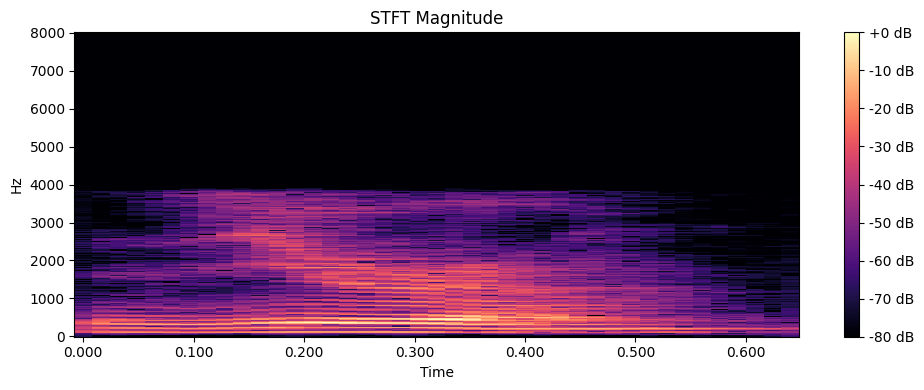

0.5초 샘플 인덱스: 8000
1.0초 샘플 인덱스: 16000


In [7]:
# =============================
# FSDD 음원 다운로드 및 준비
# =============================
# FSDD(Free Spoken Digit Dataset) GitHub에서 클론
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

# recordings 폴더만 이동
!mv free-spoken-digit-dataset/recordings recordings

# =============================
# 라이브러리 로드
# =============================
import librosa                   # 오디오 처리 라이브러리
import librosa.display           # 시각화 유틸리티
import soundfile as sf          # 오디오 저장
import numpy as np              # 수치 계산
import matplotlib.pyplot as plt # 시각화

# =============================
# 0. FSDD 음원 로드
# =============================
audio_path = 'recordings/0_jackson_0.wav'  # 0번 숫자를 발음한 파일
y, sr = librosa.load(audio_path, sr=16000) # 16kHz로 로딩

# =============================
# 2-1. 오디오 입출력
# =============================
print("샘플레이트:", sr)                           # 샘플레이트 출력
print("신호 길이:", len(y))                        # 샘플 수 출력
print("오디오 길이(초):", librosa.get_duration(y=y, sr=sr))  # 총 재생 시간(초)

sf.write("fsdd_output.wav", y, sr)                # 오디오를 파일로 저장

# =============================
# 2-2. 신호 처리 (STFT 및 복원)
# =============================
n_fft = 1024                      # 프레임당 FFT 크기
hop_length = 256                 # 홉 크기
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)  # STFT 계산
magnitude = np.abs(D)            # 복소수 STFT에서 진폭만 추출
y_reconstructed = librosa.istft(D, hop_length=hop_length) # 역변환 수행

# STFT 결과 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max),
                         sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.title("STFT Magnitude")      # 제목
plt.colorbar(format="%+2.0f dB") # 데시벨 범례
plt.tight_layout()
plt.show()

# =============================
# 2-3. 특징 추출 (MFCC, ZCR, Centroid)
# =============================
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)        # MFCC 추출 (13차원)
zcr = librosa.feature.zero_crossing_rate(y)               # 제로 크로싱 비율
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # 스펙트럼 중심
sample_05 = int(0.5 * sr)
sample_10 = int(1.0 * sr)
print("0.5초 샘플 인덱스:", sample_05)
print("1.0초 샘플 인덱스:", sample_10)
#샘플 인덱스는 **시간(초) × 샘플레이트**로 계산합니다.

#예를 들어, 16000Hz에서는 0.5초는 8000번째 샘플, 1.0초는 16000번째 샘플입니다.

공개 데이터 셋 실습

In [1]:
# FSDD 음원 다운로드
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git
!mv free-spoken-digit-dataset/recordings recordings

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [25]:
#FSDD 데이터 웨이브데이터 로딩 후 멜 스펙트럼 변환
import librosa, glob
import numpy as np
import matplotlib.pyplot as plt # 시각화
files = glob.glob("/content/recordings/*.wav")
mel_list = []

for fp in files:
    y, _ = librosa.load(fp, sr=16000)
    mel = librosa.feature.melspectrogram(y=y, sr=16000, n_fft=1024,
                                         hop_length=160, n_mels=80, power=2)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_list.append(mel_db)

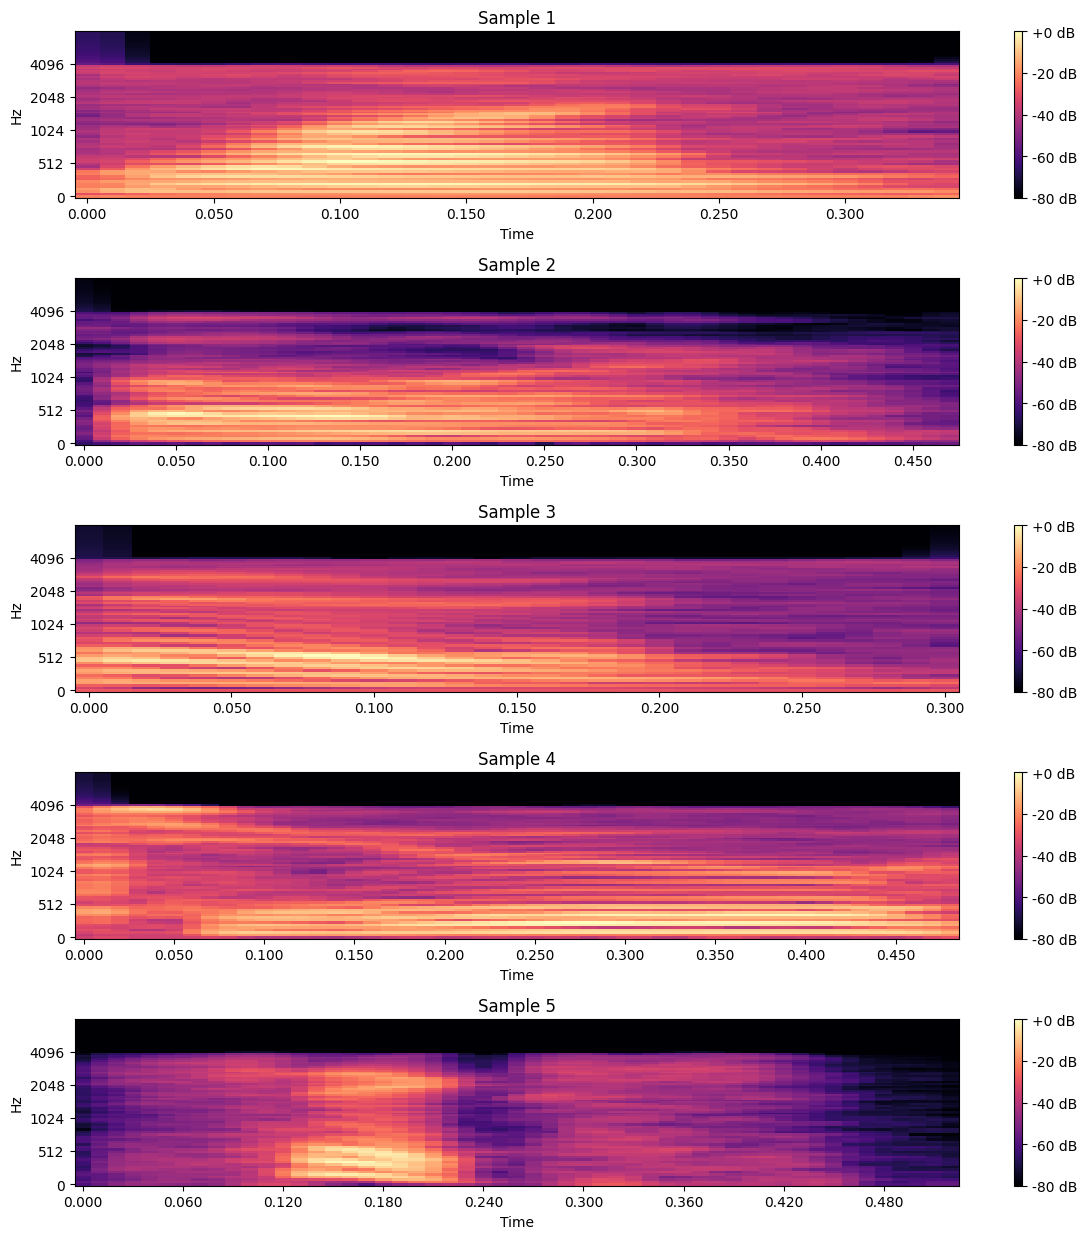

In [28]:
# 저장된 멜 스펙트럼 시각화
num_samples = min(5, len(mel_list))  # 최대 5개만

plt.figure(figsize=(12, 2.5 * num_samples))

for i in range(num_samples):
    plt.subplot(num_samples, 1, i + 1)
    librosa.display.specshow(
        mel_list[i], sr=16000, hop_length=160,
        x_axis='time', y_axis='mel', cmap='magma'
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Sample {i + 1}')

plt.tight_layout()
plt.show()

